# CNN (Convolutional Neural Network)

## - MNIST [[See the Result First](#visualized)]

#### (0) Define Hyper-parameters / Helper Function

In [1]:
import torch

In [2]:
# Device Configuration for Where the Tensors Be Operated
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjust Model Structure Depends on the Data
num_classes = 10
in_channel = 1

# Hyper-parameters
batch_size = 10
shuffle = False
max_pool_kernel = 2
learning_rate = 0.00001
num_epochs = 3

#### (1) Load Data

In [3]:
import torchvision # To Download MNIST Datasets from Torch 
import torchvision.transforms as transforms # To Transform MNIST "Images" to "Tensor"

In [4]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

test_data = torchvision.datasets.MNIST(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor())

#### (2) Define Dataloader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=shuffle)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=True)

In [6]:
# cf) check how data_loader works
image, label = next(iter(train_loader))
print(image.size(), ": [Batch, Channel, Height, Width] Respectively")

torch.Size([10, 1, 28, 28]) : [Batch, Channel, Height, Width] Respectively


#### (3) Define Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_channel, 16, 5, stride=1, padding=2),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(max_pool_kernel))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, 5, stride=1, padding=2),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(max_pool_kernel))
        self.fc1 = nn.Linear(7*7*32, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

#class ConvNet(nn.Module):
#    def __init__(self, num_classes=10):
#        super(ConvNet, self).__init__()
#        self.layer1 = nn.Sequential(
#                nn.Conv2d(in_channel, 16, 5, stride=1, padding=2),
#                nn.BatchNorm2d(16),
#                nn.ReLU(),
#                nn.MaxPool2d(max_pool_kernel))
#        self.fc1 = nn.Linear(14*14*16, num_classes)
#
#    def forward(self, x):
#        x = self.layer1(x)
#        x = x.reshape(x.size(0), -1)
#        x = F.softmax(self.fc1(x))
#        return x

model = ConvNet(num_classes).to(device) # Copy All Tensors to GPU (if possible)

In [9]:
# cf) see how the network is formed
print(model)

# cf) number of parameters
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
layer1.0.weight 	 torch.Size([16, 1, 5, 5])
layer1.0.bias 	 torch.Size([16])
layer1.1.weight 	 torch.Size([16])
layer1.1.bias 	 torch.Size([16])
layer1.1.running_mean 	 torch.Size([16])
layer1.1.running_var 	 torch.Size([16])
layer1.1.num_batches_tracked 	 torch.Size([])
layer2.0.w

<img src="../../shared/softmax.png" alt="Drawing" style="width: 800px;" align="left"/>

#### (4) Set Loss & Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### (5) Train / Test

In [11]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Assign Tensors to Configured Device
        images = images.to(device)
        labels = labels.to(device)

        # Forward Propagation
        outputs = model(images)

        # Get Loss, Compute Gradient, Update Parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print Loss for Tracking Training
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            test_image, test_label = next(iter(test_loader))
            _, test_predicted = torch.max(model(test_image.to(device)).data, 1)
            print('Testing data: [Predicted: {} / Real: {}]'.format(test_predicted, test_label))

    if epoch+1 == num_epochs:
        torch.save(model.state_dict(), 'model.pth')
    else:
        torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

# Test after Training is done
model.eval() # Set model to Evaluation Mode (Batchnorm uses moving mean/var instead of mini-batch mean/var)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader)*batch_size, 100 * correct / total))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/3], Step [100/6000], Loss: 2.2714
Testing data: [Predicted: tensor([3, 1, 1, 3, 3, 4, 4, 3, 3, 3]) / Real: tensor([0, 4, 7, 3, 5, 2, 4, 9, 7, 4])]
Epoch [1/3], Step [200/6000], Loss: 2.2739
Testing data: [Predicted: tensor([1, 3, 1, 0, 3, 9, 1, 1, 4, 1]) / Real: tensor([2, 5, 7, 5, 2, 7, 1, 1, 4, 1])]
Epoch [1/3], Step [300/6000], Loss: 2.2150
Testing data: [Predicted: tensor([3, 1, 4, 3, 6, 1, 1, 9, 0, 3]) / Real: tensor([5, 1, 4, 2, 6, 1, 9, 9, 6, 5])]
Epoch [1/3], Step [400/6000], Loss: 2.1278
Testing data: [Predicted: tensor([0, 4, 1, 0, 4, 4, 4, 1, 7, 1]) / Real: tensor([9, 9, 1, 5, 4, 9, 8, 1, 9, 1])]
Epoch [1/3], Step [500/6000], Loss: 2.0572
Testing data: [Predicted: tensor([0, 0, 1, 4, 0, 1, 0, 1, 3, 0]) / Real: tensor([0, 0, 2, 4, 0, 8, 0, 8, 5, 6])]
Epoch [1/3], Step [600/6000], Loss: 2.0962
Testing data: [Predicted: tensor([0, 3, 0, 7, 3, 1, 1, 7, 3, 1]) / Real: tensor([6, 3, 0, 9, 8, 1, 8, 7, 2, 1])]
Epoch [1/3], Step [700/6000], Loss: 2.1239
Testing data: [Predic

Epoch [1/3], Step [5400/6000], Loss: 1.7513
Testing data: [Predicted: tensor([2, 2, 0, 0, 0, 5, 2, 6, 7, 9]) / Real: tensor([2, 2, 0, 2, 0, 5, 2, 6, 7, 9])]
Epoch [1/3], Step [5500/6000], Loss: 1.5954
Testing data: [Predicted: tensor([0, 7, 3, 4, 5, 4, 5, 0, 7, 2]) / Real: tensor([0, 7, 3, 4, 5, 4, 3, 0, 7, 2])]
Epoch [1/3], Step [5600/6000], Loss: 1.4734
Testing data: [Predicted: tensor([7, 7, 2, 0, 8, 4, 7, 1, 7, 1]) / Real: tensor([7, 7, 8, 0, 8, 4, 2, 1, 7, 1])]
Epoch [1/3], Step [5700/6000], Loss: 1.6281
Testing data: [Predicted: tensor([2, 1, 6, 3, 5, 2, 0, 1, 6, 0]) / Real: tensor([2, 1, 6, 3, 5, 2, 0, 1, 6, 0])]
Epoch [1/3], Step [5800/6000], Loss: 1.4913
Testing data: [Predicted: tensor([1, 1, 9, 3, 4, 9, 0, 1, 5, 6]) / Real: tensor([1, 1, 9, 3, 4, 9, 0, 1, 5, 6])]
Epoch [1/3], Step [5900/6000], Loss: 1.4878
Testing data: [Predicted: tensor([5, 3, 1, 1, 8, 6, 0, 0, 0, 5]) / Real: tensor([5, 3, 1, 1, 8, 6, 0, 0, 0, 5])]
Epoch [1/3], Step [6000/6000], Loss: 1.5193
Testing data: 

Epoch [2/3], Step [4700/6000], Loss: 1.4794
Testing data: [Predicted: tensor([5, 7, 3, 3, 1, 7, 1, 7, 0, 8]) / Real: tensor([5, 7, 3, 3, 1, 7, 1, 7, 0, 8])]
Epoch [2/3], Step [4800/6000], Loss: 1.4723
Testing data: [Predicted: tensor([5, 7, 5, 4, 8, 0, 8, 5, 2, 8]) / Real: tensor([5, 7, 5, 4, 8, 0, 7, 5, 2, 8])]
Epoch [2/3], Step [4900/6000], Loss: 1.5377
Testing data: [Predicted: tensor([8, 4, 7, 1, 5, 5, 2, 7, 6, 5]) / Real: tensor([8, 4, 7, 1, 5, 5, 2, 7, 6, 5])]
Epoch [2/3], Step [5000/6000], Loss: 1.4857
Testing data: [Predicted: tensor([6, 1, 8, 0, 5, 1, 0, 7, 6, 9]) / Real: tensor([6, 1, 8, 0, 5, 1, 0, 7, 6, 9])]
Epoch [2/3], Step [5100/6000], Loss: 1.4855
Testing data: [Predicted: tensor([6, 6, 4, 4, 2, 6, 6, 8, 9, 7]) / Real: tensor([6, 6, 4, 4, 2, 6, 6, 8, 9, 7])]
Epoch [2/3], Step [5200/6000], Loss: 1.6324
Testing data: [Predicted: tensor([3, 0, 2, 7, 8, 5, 4, 1, 3, 1]) / Real: tensor([3, 0, 2, 7, 8, 5, 4, 1, 3, 1])]
Epoch [2/3], Step [5300/6000], Loss: 1.4667
Testing data: 

Epoch [3/3], Step [4000/6000], Loss: 1.5521
Testing data: [Predicted: tensor([6, 2, 9, 5, 4, 2, 7, 9, 8, 1]) / Real: tensor([6, 2, 9, 5, 4, 2, 7, 9, 8, 1])]
Epoch [3/3], Step [4100/6000], Loss: 1.4623
Testing data: [Predicted: tensor([3, 9, 0, 4, 8, 3, 1, 1, 4, 1]) / Real: tensor([3, 9, 0, 4, 8, 3, 1, 1, 4, 1])]
Epoch [3/3], Step [4200/6000], Loss: 1.5671
Testing data: [Predicted: tensor([5, 0, 8, 7, 4, 3, 7, 3, 6, 2]) / Real: tensor([5, 0, 8, 7, 4, 3, 7, 3, 6, 2])]
Epoch [3/3], Step [4300/6000], Loss: 1.5039
Testing data: [Predicted: tensor([7, 5, 6, 3, 1, 3, 5, 3, 4, 4]) / Real: tensor([7, 5, 6, 3, 1, 3, 5, 3, 4, 4])]
Epoch [3/3], Step [4400/6000], Loss: 1.5359
Testing data: [Predicted: tensor([0, 1, 3, 3, 8, 6, 3, 0, 9, 4]) / Real: tensor([0, 1, 3, 3, 8, 6, 3, 0, 9, 4])]
Epoch [3/3], Step [4500/6000], Loss: 1.4707
Testing data: [Predicted: tensor([2, 7, 1, 7, 0, 1, 1, 3, 3, 2]) / Real: tensor([2, 7, 1, 7, 0, 1, 1, 3, 3, 2])]
Epoch [3/3], Step [4600/6000], Loss: 1.5165
Testing data: 

<h2 id='visualized'> cf) Process in Visualization </h2>

<img src="../../shared/CNN_MNIST_process.png" alt="Drawing" style="width: 800px;" align="left"/>

#### (0) Prepare for Visualization

In [12]:
from matplotlib.pyplot import imshow
import numpy as np
# For Displaying Inline Style (Only for .ipynb fileformat)
%matplotlib inline 

visual_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=2,
                                            shuffle=True)

class ConvNetBreakDown(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNetBreakDown, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_channel, 16, 5, stride=1, padding=2),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(max_pool_kernel))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, 5, stride=1, padding=2),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(max_pool_kernel))
        self.fc1 = nn.Linear(7*7*32, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward1(self, x):
        x = self.layer1(x)
        return x
    
    def forward2(self, x):
        x = self.layer2(x)
        return x
    
    def forward3(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    def forward4(self, x):
        x = self.fc2(x)
        return x

model1 = ConvNetBreakDown()

def image_show(tensor_image):
    image = tensor_image.reshape(tensor_image.size()[1], tensor_image.size()[2])
    imshow(image, cmap='gray')

images, _ = next(iter(visual_loader))
image1 = images[0]
image2 = images[1]

#### (1) Row MNIST Image Data

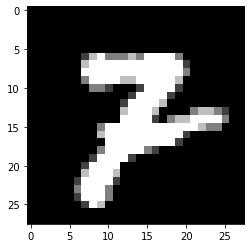

In [13]:
image_show(image1)

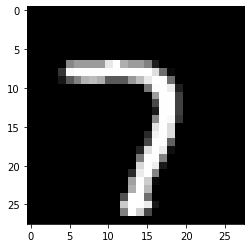

In [14]:
image_show(image2)

#### (2) After CNN1 

In [15]:

# output1 = model1(images)
output1 = model1.forward1(images)
print(output1.size())

image1 = torch.zeros(14,14)
image2 = torch.zeros(14,14)
for i in range(output1.size()[1]):
    image1 += output1[0][i].reshape(14,14)
    image2 += output1[1][i].reshape(14,14)
    
image1 = image1.detach().numpy()
image2 = image2.detach().numpy()

# show_n_images(1, 2, [temp, temp2])

torch.Size([2, 16, 14, 14])


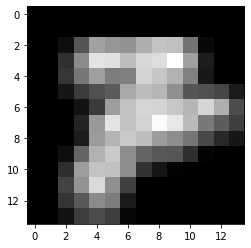

In [16]:
imshow(image1, cmap='gray')

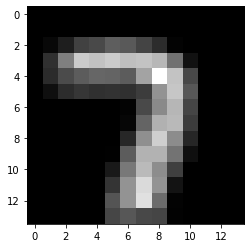

In [17]:
imshow(image2, cmap='gray')

#### (3) After CNN2

In [18]:
output2 = model1.forward2(output1)
print(output2.size())
image1 = torch.zeros(7,7)
image2 = torch.zeros(7,7)
for i in range(output2.size()[1]):
    image1 += output2[0][i].reshape(7,7)
    image2 += output2[1][i].reshape(7,7)
    
image1 = image1.detach().numpy()
image2 = image2.detach().numpy()

torch.Size([2, 32, 7, 7])


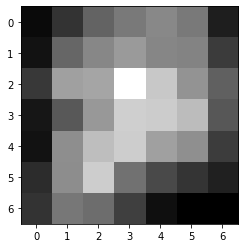

In [19]:
imshow(image1, cmap='gray')

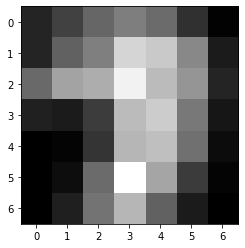

In [20]:
imshow(image2, cmap='gray')

#### (4) After Affine (Fully Connected) Layer

In [21]:
output3 = model1.forward3(output2)
print(output3.size())
image1 = output3[0]
image2 = output3[1]
    
image1 = image1.detach().numpy()
image2 = image2.detach().numpy()

output4 = model1.forward4(output3)
print(output4.size())
image1_final = output4[0]
image2_final = output4[1]
    
image1_final = image1_final.detach().numpy()
image2_final = image2_final.detach().numpy()

torch.Size([2, 120])
torch.Size([2, 10])


In [22]:
print(image1)
print("--------------------------------------------------------------------------")
print(image1_final)
print("--------------------------------------------------------------------------")
print(list(image1_final).index(image1_final.max()))

[-0.02337858 -0.2678178   1.3306266   0.3940324   0.9472509  -1.5169369
 -1.983631   -0.3174115   0.36917752 -0.11920229  0.08217466  0.8511645
 -0.20488779 -0.26989353 -0.43249005  0.51765627 -0.39033395 -0.32686338
  1.440205    0.32147992 -1.6649002  -0.47386897  0.27898955 -0.6301607
  0.00831714 -0.4156308   0.15957013 -1.1028038  -0.58005524  0.34367836
  0.25880444  0.7528628  -0.03889595 -0.37316954 -0.22837397  0.22389583
  0.15148284  0.54468054  0.03610839  0.06004722 -0.30017078  0.2672003
  0.6483822   0.5825532  -0.60200423  0.738138    0.2787594  -0.09702545
  1.282822   -0.385741   -0.87626535 -0.44130683 -0.4647764   0.13512833
 -0.38403848  0.13420662  0.2980501  -0.6317556  -0.29158884 -0.7178237
 -1.5042399  -0.28546208  0.21600072 -0.46178398  0.7290343  -0.56695783
 -0.3558444   0.61223936 -0.49868092  0.27889675 -0.3947778  -0.92127967
  1.2770573   0.7394395   0.5399979   0.18660833  0.31998968  0.7001457
 -0.0373721  -0.12124054  0.20375594  0.34004897 -1.04432

In [23]:
print(image2)
print("--------------------------------------------------------------------------")
print(image2_final)
print("--------------------------------------------------------------------------")
print(list(image2_final).index(image2_final.max()))

[ 0.07495224 -0.20977002  0.11497054  0.19474342  0.36837476  0.0163836
 -0.87438804 -0.17489117 -0.08174929 -0.08705129 -0.17019646  0.10848459
 -0.16333538 -0.4371122  -1.0953498  -0.16384095 -0.441641   -0.61608917
  0.68703896 -0.01952407 -1.111576   -0.00248506 -0.05206943 -0.04170857
 -0.3018034   0.3419768  -0.8685432   0.01116402 -0.28500375  0.05597348
 -0.09501192  0.8192414  -0.12390502 -0.16134478 -0.4552295   0.03630499
  0.71591854  0.54306734 -0.38311368  0.1282589  -0.06762393  0.15089053
 -0.55533904  0.22950521 -0.38252312  0.9741996   0.27726743 -0.61308575
  0.41497377 -0.0380067   0.09536761  0.30487603 -0.3898705  -0.00363224
  0.0383198  -0.52351743 -0.4290364  -0.80456823 -0.15618443 -0.7125625
 -0.61607766  0.18905948 -0.09937052 -0.5220593   0.5126646  -0.65930337
 -0.02665955  0.27743927 -1.1175517   0.22945967 -0.5427601  -0.20303097
  0.7415756   0.12727831  0.3955673   0.4322294  -0.41617426  0.5449728
  0.14125673  0.36622563 -0.00201    -0.11233611  0.14

#### cf) MNIST Distribution

<img src="../../shared/MNIST_sample.png" alt="Drawing" style="width: 500px;" align="left"/>